In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import mglearn
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

/home/florian/IA/envs/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/florian/IA/envs/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Etiquetamos los nombres de las características en el dataset.

In [2]:
featuresNames = ['MeanIntegratedProfile',
                'StdIntegratedProfile',
                'ExcessKurtosisIntegratedProfile',
                'SkewnessIntegratedProfile',
                'MeanDMSNRCurve',
                'StdDMSNRCurve',
                'ExcessKurtosisDMSNRCurve',
                'SkewnessDMSNRCurve',
                'Class']

Cargamos la informacion del dataset HTRU2.

In [3]:
data = pd.read_csv('../HTRU_2.csv',
                   header = None, 
                   names = featuresNames)

Separamos la variable categórica del dataset.

In [4]:
x = data.drop('Class', axis = 1, inplace = False)
y = data['Class']

Como podemos observar, existen variables que varian en un rango mayor de valores que otras. Para realizar una mejor comparacion entre las variables es importante estandarizar las variables con una media de cero y una desviación estándar de 1.

In [5]:
scaler = StandardScaler()
normalized_x = scaler.fit_transform(x)

Se divide el dataset en dos conjuntos de datos: entrenamiento y pruebas. El conjunto de entrenamiento estará compuesto por el 90% del dataset y pruebas del 10%.

El dataset HTRU2 es un conjunto de datos desbalanceado, por cada púlsar identificado, diez no lo son. Para que esta misma proporción se refleje en los conjuntos de entrenamiento y pruebas se realizará una división estratificada.

In [6]:
y.value_counts()

0    16259
1     1639
Name: Class, dtype: int64

In [7]:
x_train, x_test, y_train, y_test = train_test_split(normalized_x,
                                                    y,
                                                    test_size = 0.1,
                                                    random_state = 0,
                                                    stratify = y)

Ahora ambos conjuntos de datos tienen la misma proporción con respecto a la variable categórica.

In [8]:
print(y_train.value_counts())
print(y_test.value_counts())

0    14633
1     1475
Name: Class, dtype: int64
0    1626
1     164
Name: Class, dtype: int64


Como mencionamos anteriormente, el dataset HTRU2 es conjunto de datos desbalanceado. Para balancear utilizaremos una técnica de oversampling llamada SMOTE, donde se genera nuevas instancias de la clase minoritaria interpolando los valores de las instancias minoritarias más cercanas a una dada. El nuevo ratio será de 1:5, esto quiere decir, que por cada púlsar, cinco no lo serán en el conjunto de entrenamiento.

In [9]:
smote = SMOTE(random_state = 0,
             ratio = 0.20)
x_train_smote, y_train_smote = smote.fit_sample(x_train, y_train.ravel())

Ahora podemos observar que el conjunto de datos se encuentra balanceado.

In [10]:
np.bincount(y_train_smote)

array([14633,  2926])

Para encontrar los mejores hiper-parámetros que se ajusten al modelo utilizaremos la técnica de búsqueda en grilla.

Para determinar los mejores valores de C, max_iter, solver y tol será necesario probar el modelo con diferentes valores.

En cada iteración se realizará validación cruzada con k = 5.

La métrica de evaluación será f1.

In [11]:
param_grid = {  
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [100, 200, 500, 1000],
    'solver': ['newton-cg', 'lbfgs'],
    'tol': [0.001, 0.0001, 0.0001]
}

grid_search = GridSearchCV(estimator = LogisticRegression(),
                           param_grid = param_grid,
                           scoring = 'f1',
                           cv = 5)

grid_search.fit(x_train_smote, y_train_smote)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'max_iter': [100, 200, 500, 1000],
                         'solver': ['newton-cg', 'lbfgs'],
                         'tol': [0.001, 0.0001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [13]:
print('Tuneando los hiper-parámetros para f1')
print()

print('Los mejores hiper-parámetros encontrados con validación cruzada:')
print()
print(grid_search.best_params_)
print()
print('Puntajes de la métrica f1 en el conjunto de validación:')
print()
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print('%0.4f (+/-%0.04f) for %r'
          % (mean, std * 2, params))

Tuneando los hiper-parámetros para f1

Los mejores hiper-parámetros encontrados con validación cruzada:

{'C': 10, 'max_iter': 100, 'solver': 'newton-cg', 'tol': 0.001}

Puntajes de la métrica f1 en el conjunto de validación:

0.8787 (+/-0.0200) for {'C': 0.01, 'max_iter': 100, 'solver': 'newton-cg', 'tol': 0.001}
0.8787 (+/-0.0200) for {'C': 0.01, 'max_iter': 100, 'solver': 'newton-cg', 'tol': 0.0001}
0.8787 (+/-0.0200) for {'C': 0.01, 'max_iter': 100, 'solver': 'newton-cg', 'tol': 0.0001}
0.8787 (+/-0.0200) for {'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs', 'tol': 0.001}
0.8787 (+/-0.0200) for {'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs', 'tol': 0.0001}
0.8787 (+/-0.0200) for {'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs', 'tol': 0.0001}
0.8787 (+/-0.0200) for {'C': 0.01, 'max_iter': 200, 'solver': 'newton-cg', 'tol': 0.001}
0.8787 (+/-0.0200) for {'C': 0.01, 'max_iter': 200, 'solver': 'newton-cg', 'tol': 0.0001}
0.8787 (+/-0.0200) for {'C': 0.01, 'max_iter': 200, 'solver': 'newto

La búsqueda en grilla nos devuelve el modelo con los mejores hiper-parámetros.

Finalmente, vamos a predecir los resultados del modelo con los conjuntos de datos de entrenamiento y pruebas.

In [12]:
logistic_regression_model = grid_search

logistic_regression_model_train_prediction = logistic_regression_model.predict(x_train_smote)
logistic_regression_model_test_prediction = logistic_regression_model.predict(x_test)

In [13]:
print('Regresión logística')
print('\t-Mejores hiper-parámetros: ' + str(logistic_regression_model.best_params_))
print('\t-Puntaje f1 en entrenamiento: %.4f' % f1_score(y_train_smote, logistic_regression_model_train_prediction, average = 'binary'))
print('\t-Puntaje f1 en pruebas: %.4f' % f1_score(y_test, logistic_regression_model_test_prediction, average = 'binary'))

Regresión logística
	-Mejores hiper-parámetros: {'C': 10, 'max_iter': 100, 'solver': 'newton-cg', 'tol': 0.001}
	-Puntaje f1 en entrenamiento: 0.9066
	-Puntaje f1 en pruebas: 0.9024


In [14]:
predictionssss = logistic_regression_model_test_prediction
invalid = []
valid = []
invalidClass = []
validClass = []
k = 0
for it in y_test:
    if(predictionssss[k] != it):
        invalid.append(x_test[k])
        invalidClass.append(it)
    else:
        valid.append(x_test[k])
        validClass.append(it)
        
    k = k + 1
    
print(len(invalid))
print(len(invalidClass))

32
32


Text(0, 0.5, 'PCA 2')

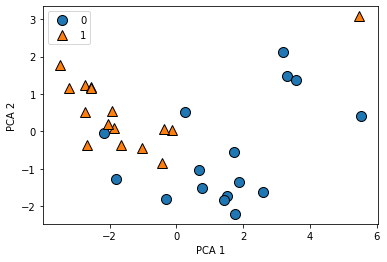

In [15]:
pca = PCA().fit(invalid)
transformada = pca.transform(invalid)
mglearn.discrete_scatter(transformada[:,0], transformada[:,1], invalidClass)
plt.legend(y.unique(), loc = 'best')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Text(0, 0.5, 'PCA 2')

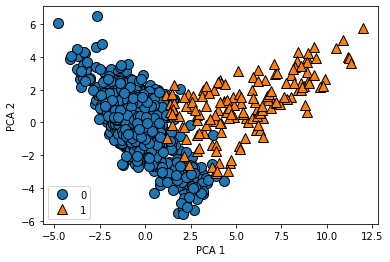

In [16]:
pca = PCA().fit(valid)
transformada = pca.transform(valid)
mglearn.discrete_scatter(transformada[:,0], transformada[:,1], validClass)
plt.legend(y.unique(), loc = 'best')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')